In [ ]:
pip install tabulate


Liberary

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

Load Datset

In [123]:
data_train_path ='Fruits_Vegetables/train'
data_test_path ='Fruits_Vegetables/test'
data_val_path  ='Fruits_Vegetables/validation'

In [124]:
img_width =180
img_height =180

In [125]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width,img_height),
    batch_size=32,
    validation_split=False
)

Found 3115 files belonging to 36 classes.


In [126]:
data_cat=data_train.class_names

In [127]:
data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    shuffle=False,
    image_size=(img_width,img_height),
    batch_size=32,
    validation_split=False
)

Found 351 files belonging to 36 classes.


In [128]:
data_test=tf.keras.utils.image_dataset_from_directory(
     data_test_path,
    shuffle=False,
    image_size=(img_width,img_height),
    batch_size=32,
    validation_split=False
)

Found 359 files belonging to 36 classes.


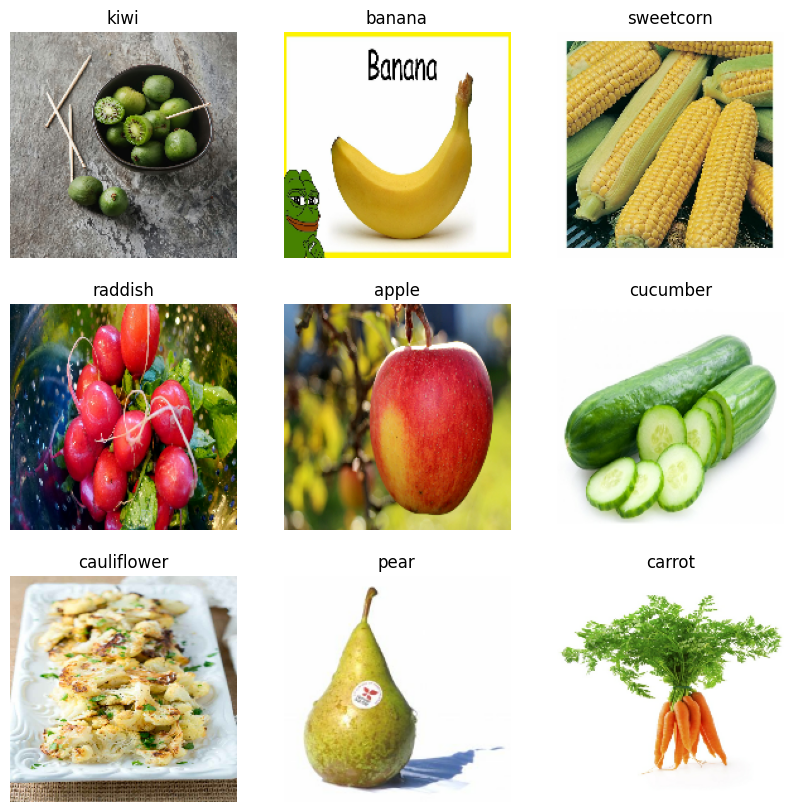

In [135]:
plt.figure(figsize=(10,10))
for image,labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')

Model

In [136]:
from tensorflow.keras.models import Sequential

Optimize Data Input Pipeline


In [148]:
data_train = data_train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
data_val = data_val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Mixed Precision Training

In [149]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

ImportError: cannot import name 'experimental' from 'tensorflow.keras.mixed_precision' (c:\Users\MSI PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\api\_v2\keras\mixed_precision\__init__.py)

Data Augmentation Layer

In [150]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    #layers.RandomZoom(0.2),
])

In [151]:
model = Sequential([
    # Data Augmentation
    data_augmentation,
    
    # Input Scaling
    layers.Rescaling(1./255),

    # First Convolutional Block
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(),
    
    # Second Convolutional Block
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(),
    
    # Third Convolutional Block
    layers.Conv2D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(),
    
    # Global Average Pooling Layer
    layers.GlobalAveragePooling2D(),
    
    # Dropout for Regularization
    layers.Dropout(0.3),
    
    # Fully Connected Dense Layers
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    
    # Output Layer with Softmax Activation
    layers.Dense(units=len(data_cat), activation='softmax')
])


Compile the Model with Adam Optimizer and Learning Rate Scheduler 

In [154]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

Early Stopping


In [155]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10,
                               restore_best_weights=True, verbose=1)

Checkpoint 

In [156]:

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='models/best_model.h5',  # Path where the best model will be saved
    monitor='val_loss',        # Metric to monitor
    save_best_only=True,        # Save only the best model
    save_weights_only=False,   # Save the entire model (including architecture)
    mode='min',                # Mode for monitoring (minimize the loss)
    verbose=1                  # Verbosity level
)



In [159]:
epochs_size=50
history = model.fit(data_train,
                    validation_data=data_val,
                    epochs=epochs_size,
                    batch_size=32,
                    verbose=1,
                    callbacks=[lr_scheduler, checkpoint,early_stopping] )


Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 1.9471 - accuracy: 0.4058
Epoch 1: val_loss did not improve from 1.60366
98/98 [==============================] - 132s 1s/step - loss: 1.9471 - accuracy: 0.4058 - val_loss: 1.6633 - val_accuracy: 0.5014 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - ETA: 0s - loss: 1.9235 - accuracy: 0.4090
Epoch 2: val_loss did not improve from 1.60366
98/98 [==============================] - 133s 1s/step - loss: 1.9235 - accuracy: 0.4090 - val_loss: 1.7133 - val_accuracy: 0.4872 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - ETA: 0s - loss: 1.8927 - accuracy: 0.4250
Epoch 3: val_loss improved from 1.60366 to 1.39064, saving model to models\best_model.h5
98/98 [==============================] - 133s 1s/step - loss: 1.8927 - accuracy: 0.4250 - val_loss: 1.3906 - val_accuracy: 0.6068 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - ETA: 0s - loss: 1.8453 - accuracy: 0.4299
Epoch 4: val

Text(0.5, 1.0, 'Loss')

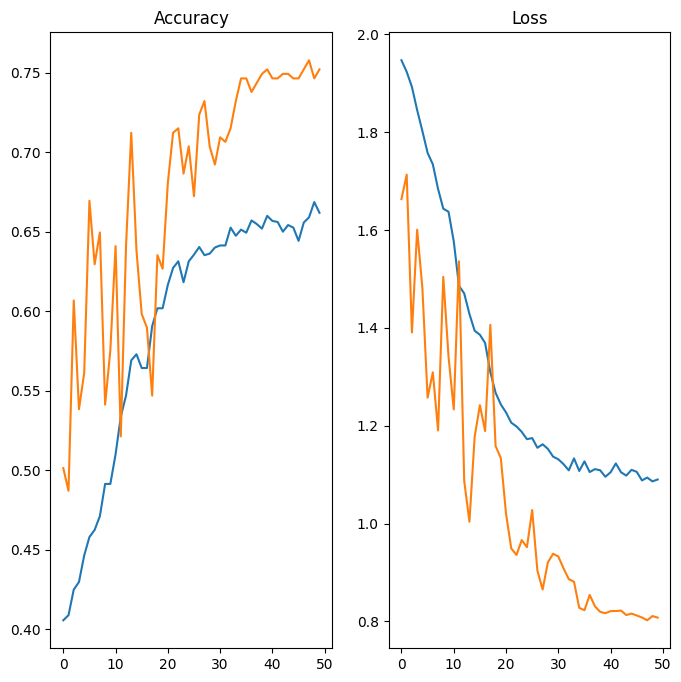

In [160]:
epoch_range =range(epochs_size)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epoch_range,history.history['accuracy'],label='Training Accuracy')
plt.plot(epoch_range,history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epoch_range,history.history['loss'],label='Training Loss')
plt.plot(epoch_range,history.history['val_loss'],label='Validation Loss')
plt.title('Loss')

In [167]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
image='Appel2.jpg'
image = tf.keras.utils.load_img(image,target_size=(img_height,img_width))
img_arr = tf.keras.utils.img_to_array(image)
img_bat =tf.expand_dims(img_arr,0)

In [168]:
predict = model.predict(img_bat)

1/1 [==============================] - 0s 61ms/step


In [169]:
score = tf.nn.softmax(predict)

In [170]:
print('Veg/Fruit in image is {} with accuracy of {:.2f}%'.format(data_cat[np.argmax(score)], np.max(score) * 100))


Veg/Fruit in image is apple with accuracy of 6.25%


In [171]:
model.save('Image_classify2.keras')

In [101]:
from tensorflow.keras.models import load_model

# Load the model
classsifay = load_model('Image_classify1.keras')
predict = classsifay.predict(img_bat)
score = tf.nn.softmax(predict)
print('Veg/Fruit in image is {} with accuracy of {:.2f}%'.format(data_cat[np.argmax(score)], np.max(score) * 100))


1/1 [==============================] - 0s 235ms/step
Veg/Fruit in image is pomegranate with accuracy of 4.44%


before

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import load_model
data_train_path="Fruits_Vegetables/train"
img_height , img_width=180,180
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width,img_height),
    batch_size=32,
    validation_split=False
)
data_cat=data_train.class_names

Found 3115 files belonging to 36 classes.


In [14]:

image='garlic.jpg'
image = tf.keras.utils.load_img(image,target_size=(img_height,img_width))
img_arr = tf.keras.utils.img_to_array(image)
img_bat =tf.expand_dims(img_arr,0)
num_top_predictions=6
for a in range(2):
    classsifay = load_model(f'Image_classify{a+1}.keras')
    predict = classsifay.predict(img_bat)

    # Convert predictions to probabilities
    probabilities = tf.nn.softmax(predict[0]).numpy()  # Convert Tensor to NumPy array
    # Get the indices of the top 2 classes
    top_indices = np.argsort(probabilities)[::-1][:num_top_predictions]  # Sort in descending order and take the top 2

    # Get the top 2 probabilities and their corresponding class names
    top_probabilities = probabilities[top_indices]
    top_classes = [data_cat[i] for i in top_indices]
    if a == 0:
        print("First prediction")
    else:
        print("Second prediction")
    
    # Print the top 2 predictions
    print('Top 2 predictions:')
    for cls, prob in zip(top_classes, top_probabilities):
        print(f'{cls}: {prob * 100:.2f}%')

1/1 [==============================] - 0s 241ms/step
First prediction
Top 2 predictions:
garlic: 3.90%
potato: 3.33%
ginger: 3.17%
onion: 3.00%
sweetpotato: 2.89%
turnip: 2.74%
1/1 [==============================] - 0s 241ms/step
Second prediction
Top 2 predictions:
garlic: 6.00%
ginger: 2.97%
potato: 2.77%
eggplant: 2.71%
onion: 2.70%
sweetpotato: 2.69%


In [70]:
#%pip show streamlit
#%pip show python-dotenv
#%pip show PyPDF2
#%pip show langchain
#%pip show faiss-cpu


Name: faiss-cpu
Version: 1.8.0.post1
Summary: A library for efficient similarity search and clustering of dense vectors.
Home-page: 
Author: 
Author-email: Kota Yamaguchi <yamaguchi_kota@cyberagent.co.jp>
License: MIT License
Location: c:\users\msi pc\appdata\local\programs\python\python310\lib\site-packages
Requires: numpy, packaging
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [63]:
from tabulate import tabulate

image = 'personne/manel.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height, img_width))
img_arr = tf.keras.utils.img_to_array(image)
img_bat = tf.expand_dims(img_arr, 0)

probabilities_per_class = {cls: [0.0, 0.0] for cls in data_cat}

num_top_predictions = 4  # Adjust as needed

for a in range(2):
    classsifay = load_model(f'Image_classify{a+1}.keras')
    predict = classsifay.predict(img_bat)

    # Convert predictions to probabilities
    probabilities = tf.nn.softmax(predict[0]).numpy()  # Convert Tensor to NumPy array

    # Store the probabilities for each class
    for i, prob in enumerate(probabilities):
        probabilities_per_class[data_cat[i]][a] = prob

# Sum the probabilities for each class
summed_probabilities = {cls: sum(probs) for cls, probs in probabilities_per_class.items()}

# Sort the classes by their summed probabilities in descending order
sorted_classes = sorted(summed_probabilities.items(), key=lambda x: x[1], reverse=True)[:num_top_predictions]

# Create a table of summed top predictions with individual model probabilities
table_data = [["Class", "Probability Model 1 (%)", "Probability Model 2 (%)", "Summed Probability (%)"]]
for cls, summed_prob in sorted_classes:
    prob_model_1 = probabilities_per_class[cls][0] * 100
    prob_model_2 = probabilities_per_class[cls][1] * 100
    table_data.append([cls, f'{prob_model_1:.2f}%', f'{prob_model_2:.2f}%', f'{summed_prob * 100:.2f}%'])

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

1/1 [==============================] - 0s 248ms/step
+-----------+---------------------------+---------------------------+--------------------------+
| Class     | Probability Model 1 (%)   | Probability Model 2 (%)   | Summed Probability (%)   |
+===========+===========================+===========================+==========================+
| carrot    | 2.93%                     | 3.55%                     | 6.48%                    |
+-----------+---------------------------+---------------------------+--------------------------+
| pineapple | 3.47%                     | 2.83%                     | 6.30%                    |
+-----------+---------------------------+---------------------------+--------------------------+
| orange    | 2.89%                     | 3.25%                     | 6.14%                    |
+-----------+---------------------------+---------------------------+--------------------------+
| grapes    | 3.10%                     | 2.73%                     | 5.83